# Applications
## First passage times
Suppose $N=2$. We start at $S_0=2$ (unemployed). How long does it take to find a job?

Suppose you're tossing coins. How many tosses until first head?

$T_t$: time left before becoming employed, after having been unemp for $t$ periods. Problem: find $E(T_0)$.
$$
\Pr(T_t=1|S_t=2) = P_{21}
$$
with prob $P_{22}$:
$$
T_t = 1 + T_{t+1}
$$
Pretend it is a Bellman
$$
E(T_t) = 1 + P_{22} E(T_{t+1}) + P_{21}\cdot 0
$$
Note that by Markov, $T_t = T_{t+1} = T$
$$
E(T) = 1 + P_{22} E(T)
$$
$$
E(T) = \frac {1}
	{1-P_{22}} = 1/P_{21}
$$


In [1]:
using Random
function draw_random_state(pmf::Vector{Float64})
    prob = pmf ./ sum(pmf, dims=1)
    CDF = cumsum(prob, dims=1)
    u = rand() # this is uniform random [0,1)
    return sum(u .>= CDF) + 1
end

draw_random_state (generic function with 1 method)

In [3]:
function simulate_first_time_to_reach_state(P::Array{Float64, 2}, start_from::Int64, end_at::Int64)
    state = start_from
    T = 0
    while state != end_at
        T = 1 + T
        state = draw_random_state(P[state, :])
    end
    return T
end

simulate_first_time_to_reach_state (generic function with 1 method)

In [20]:
P = [.9 0.05 0.05; 0 0.8 0.2; 32 47 -3]
simulate_first_time_to_reach_state(P, 1, 3)

6

In [24]:
using Plots
function histogram_of_T(P::Array{Float64, 2})
    N = 1000
    T = zeros(N)
    for n = 1:N
        T[n] = simulate_first_time_to_reach_state(P, 1, size(P, 1))
    end
    histogram(T)
end

histogram_of_T (generic function with 1 method)

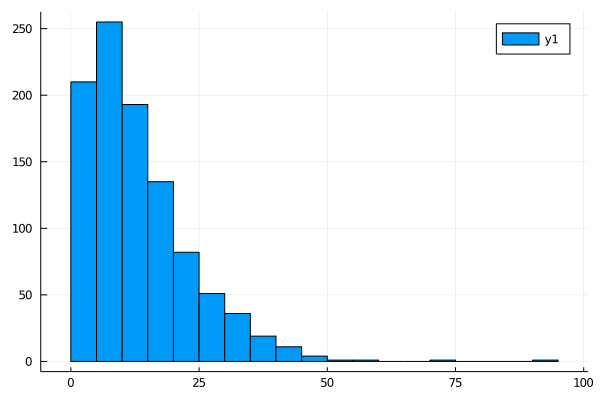

In [25]:
histogram_of_T(P)

### With $N>2$
$T_i$: expected time to reach $N$ if in state $i$ ($T_N=0$)
Bellman
$$
T_i = 1 + E(T_s)
$$
$$
T_i = 1 + \sum_{k=1}^N P_{ik}T_k
$$
$$
\mathbf T = \mathbf 1 + \mathbf P \mathbf T
$$
with $\mathbf T$ an $N\times 1$ vector. $T_n=0$

$$
\mathbf T_{-n} = \mathbf 1 + \mathbf P_{-n} 
\begin{pmatrix}
\mathbf T_{-n}\\
0
\end{pmatrix}
$$
with $\mathbf T_{-n}$ an $(N-1)\times 1$ vector. and $\mathbf P_{-n}$ is $(N-1)\times N$

$$
(\mathbf I - \mathbf P) \mathbf T = \mathbf 1	 
$$


In [40]:
function solve_T_with_Bellman(P::Array{Float64, 2})
    threshold = 0.00001
    N = size(P, 1)
    T = zeros(N)
    old_T = zeros(N)
    distance = 999 * threshold
    while distance > threshold
        T = 1 .+ P * old_T
        T[N] = 0
        distance = maximum(abs.(T .- old_T))
        old_T = T
    end
    return T
end

solve_T_with_Bellman (generic function with 1 method)

In [41]:
T = solve_T_with_Bellman(P)

3-element Array{Float64,1}:
 12.499917968670616
  4.999999999964165
  0.0

In [29]:
P

3×3 Array{Float64,2}:
  0.9   0.05   0.05
  0.0   0.8    0.2
 32.0  47.0   -3.0

### Coupon collector's problem
$K$ different types of coupons. Buy $N$ random ones so that we have at least 1 of each type. $E(N)=?$

With Bellman. State $k$: we already have $k$ different types of coupons. 

$N_k$: expected number of additional coupons to buy after this state.
$$
N_k = 0 
$$
for $k=K$
$$
N_k = 1 + \frac kK N_k+\frac{K-k}{K} N_{k+1}
$$
$$
\frac {K-k}K N_k = 
1 + \frac{K-k}K N_{k+1}
$$
$$
N_k = \frac K{K-k} + N_{k+1}
$$
Iterate for $k=K-1,...,1$.

## Long-term unemployment
$T+2$ states: $0$ is employment, $t=1,...,T+1$ means person is in month $t$ of unemployment.

$w$ wage when employed

$b_1$ for $t\le T$, higher unemployment benefit
$b_2<b_1$ when $t>T$

$$
V_0 = w +\beta
[(1-P_{01})V_0 + P_{01} V_1]
$$
for $t\le T$
$$
V_t = b_1+ \beta
[(1-P_{t0})V_{t+1} + P_{t0} V_0]
$$
$$
V_{T+1} = b_2 + \beta
[(1-P_{T+1,0}) V_{T+1} + P_{T+1,0}V_0]
$$
Recursive formulation:
1. Take a $V_0$
2. Use Bellman for $0$ to solve for $V_1$
3. Use Bellman for $t=1$ to solve for $V_2$...
4. Obtain $V_{T+1}$.
5. Use the Bellman for $t=T+1$ to verify that $V_0$ was correct.

## Endogenous search
$$
P_{t0} = 1 - \exp(-\lambda e_t)
$$
effort enter utility linearly
$$
b_1 - e_t
$$

$$
V_0 = w +\beta
[(1-P_{01})V_0 + P_{01} V_1]\tag{**}
$$
for $t\le T$
$$
V_t = \max_{e_t} b_1 - e_t + 
\beta
[\exp(-\lambda e_t)V_{t+1} + (1-\exp(-\lambda e_t)) V_0]
$$
$$
V_{T+1} = \max_{e_{T+1}} b_2 - e_{T+1}
$$
$$+ \beta
[\exp(-\lambda e_{T+1}) V_{T+1} + (1-\exp(-\lambda e_{T+1}))V_0]
$$
FOC
$$
\beta
[\lambda \exp(-\lambda e_t)(V_0 - V_{t+1})] = 1
$$
$$
\exp(-\lambda e_t) = 
\frac{1}
{\beta\lambda (V_0-V_{t+1})}
$$
$$
e_t = \frac 1\lambda
[\ln \beta + \ln \lambda + \ln(V_0-V_{t+1})]
\tag{*}
$$


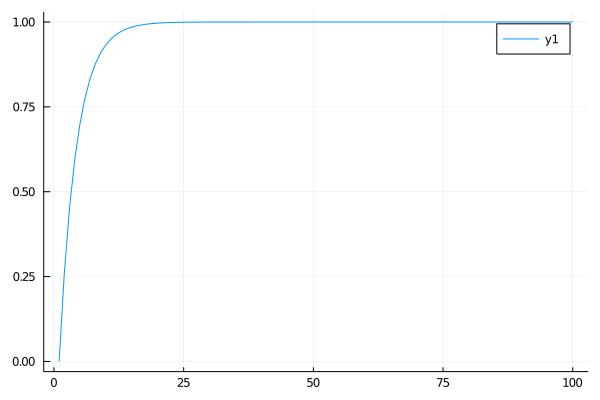

In [24]:
using Plots
function draw_exponential(lambda::Real)
    N = 100
    y = zeros(N)
    for n = 1:N
        y[n] = 1 - exp(-lambda * (n-1))
    end
    plot(y)
end
draw_exponential(0.3)

In [27]:
function iterate_value_function(V::Array{Float64,1}, w::Float64, b1::Float64, b2::Float64, β::Float64, λ::Float64, μ::Float64)
    T = length(V) - 2
    new_V = similar(V)
    effort = similar(V)
    # what if changing in place
    
    # unlike in eq (**), denote employment state with T+2 (as opposed to 0, which is not a valid julia index)
    new_V[T+2] = w + β*((1-μ)*V[T+2] + μ*V[1])
    effort[T+2] = 0.0
    # for every other state, use same index t as in formula
    for t = 1:T
        effort[t] = max(0, 1/λ*(log(β) + log(λ) + log(V[T+2]-V[t+1])))
        prob_find_job = 1 - exp(-λ*effort[t])
        # i had a mistake before, not subtracting effort from current payoff
        new_V[t] = b1 - effort[t] + β*(prob_find_job*V[T+2] + (1-prob_find_job)*V[t+1])
    end
    # long-term unemployed
    effort[T+1] = max(0, 1/λ*(log(β) + log(λ) + log(V[T+2]-V[T+1])))
    prob_find_job = 1 - exp(-λ*effort[T+1])
    new_V[T+1] = b2 -effort[T+1] + β*(prob_find_job*V[T+2] + (1-prob_find_job)*V[T+1])
    return new_V, effort
end

iterate_value_function (generic function with 2 methods)

In [4]:
A = [1 2; 3 4]
B = similar(A)
C = zeros(size(A))

2×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0

In [30]:
V = zeros(8)
effort = similar(V)
λ = 0.03
for k = 1:200000
    new_V, effort = iterate_value_function(V, 1.0, 0.6, 0.2, 0.995, λ, 0.01)
    V = new_V
end
println(V)
println(1 .- exp.(-λ*effort))

[92.53214467991339, 92.29219883155308, 92.03080485319687, 91.74389594734241, 91.42638070281691, 91.07179362384062, 90.67179362384063, 128.47457120836833]
[0.07411163723458536, 0.08075259855286099, 0.08793298018985762, 0.09574969617158036, 0.10432220053100494, 0.11379957607534141, 0.11379957607534141, 0.0]


In [6]:
1-exp(-0.6*0.1)

0.05823546641575128